# Installs & Imports

In [1]:
install.packages(c(
    "quantmod",
    "rugarch",
    "ggplot2",
    "dplyr",
    "Metrics",
    "lubridate",
    "rsample",
    "purrr",
    "tidyr",
    "forecast",
    "zoo"
))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(quantmod)
library(rugarch)
library(ggplot2)
library(dplyr)
library(Metrics)
library(lubridate)
library(rsample)
library(purrr)
library(tidyr)
library(forecast)
library(zoo)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #

# Data Loading

In [3]:
# Function to download the data
download_data <- function(symbol = "NVDA") {
  xts_data <- tryCatch(
    getSymbols(symbol, src = "yahoo", auto.assign = FALSE),
    error = function(e) stop("Error downloading data: ", e$message)
  )
  df <- data.frame(Date = index(xts_data),
                   Close = as.numeric(Ad(xts_data))) %>%
    arrange(Date)
  return(df)
}

In [4]:
# Load the data
symbol <- "NVDA"
data_all <- download_data(symbol)

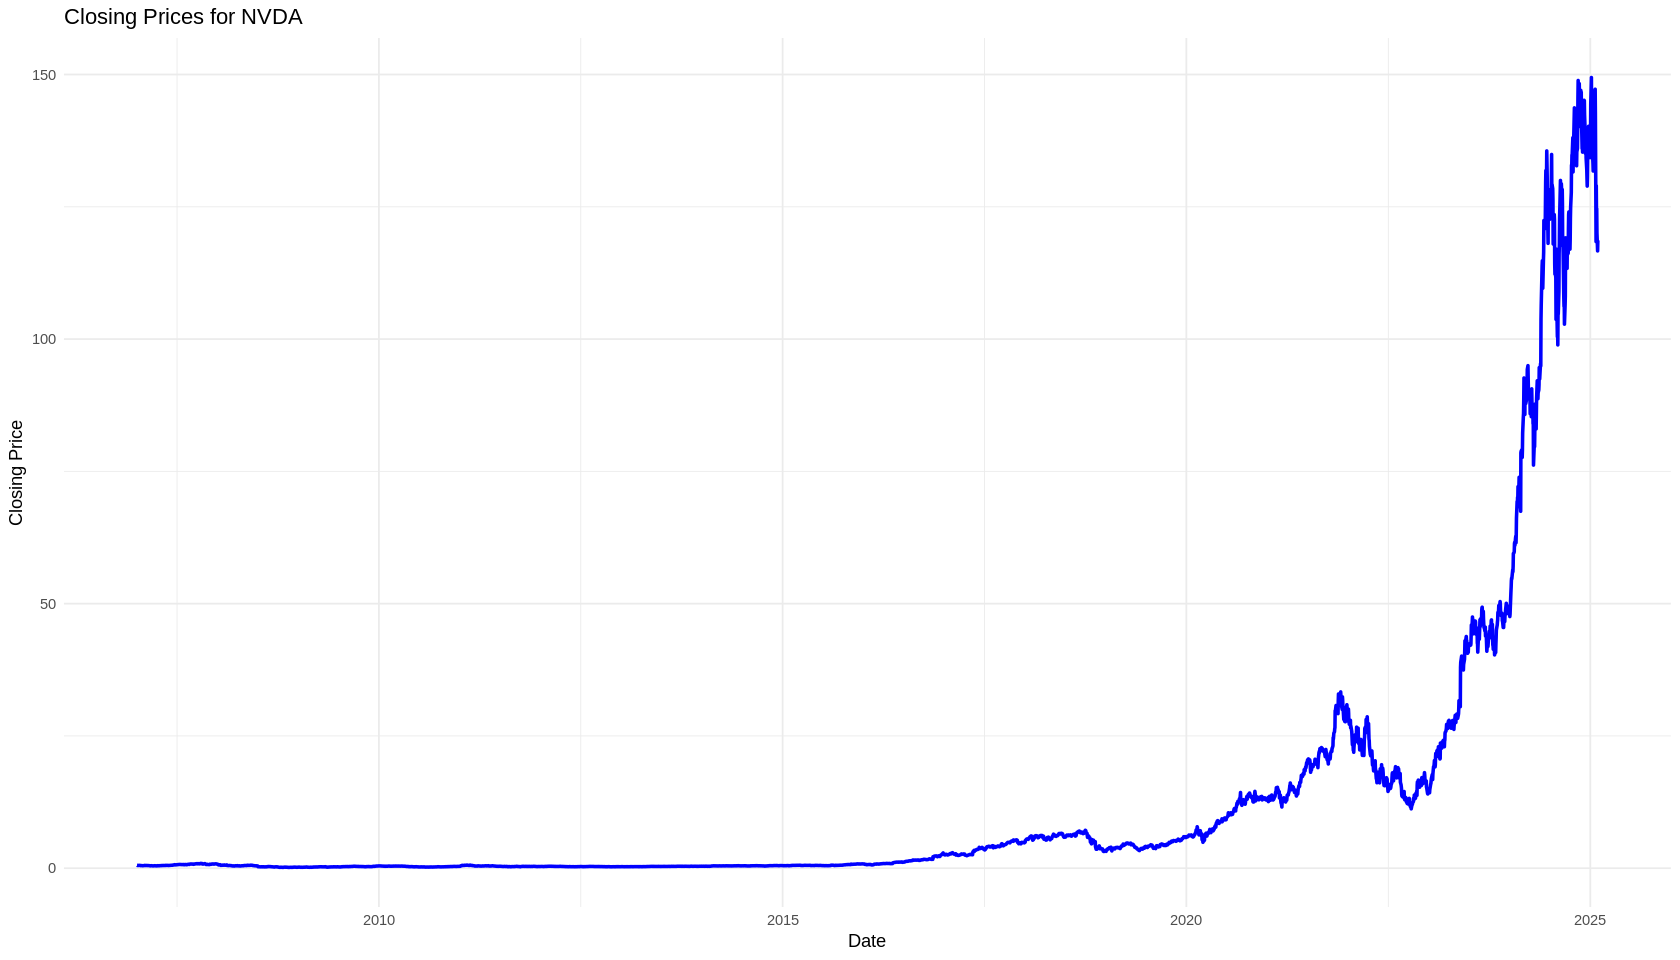

In [5]:
# Plot the data
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_all, aes(x = Date, y = Close)) +
  geom_line(color = "blue", linewidth = 1) +
  labs(title = paste("Closing Prices for", symbol),
       x = "Date",
       y = "Closing Price") +
  theme_minimal()

In [6]:
# Function to calculate log returns
calculate_log_returns <- function(data, price_col = "Close") {

  # Ensure the column exists in the data
  if (!price_col %in% names(data)) {
    stop(paste("Column", price_col, "not found in data"))
  }

  # Calculate log returns and add as a new column
  data <- data %>%
    mutate(LogReturn = c(NA, diff(log(.data[[price_col]]))))

  # Remove the first row (NA LogReturn)
  data <- na.omit(data)
  return(data)
}

# Calculate the log returns and store in a new data frame (or overwrite data_all).
data_all <- calculate_log_returns(data_all)
head(data_all)

,Date,Close,LogReturn
,<date>,<dbl>,<dbl>
2,2007-01-04,0.5488755,-0.004722449
3,2007-01-05,0.5144849,-0.064705488
4,2007-01-08,0.5183063,0.007400122
5,2007-01-09,0.5082182,-0.019655472
6,2007-01-10,0.5332851,0.048145321
7,2007-01-11,0.5312977,-0.003733669


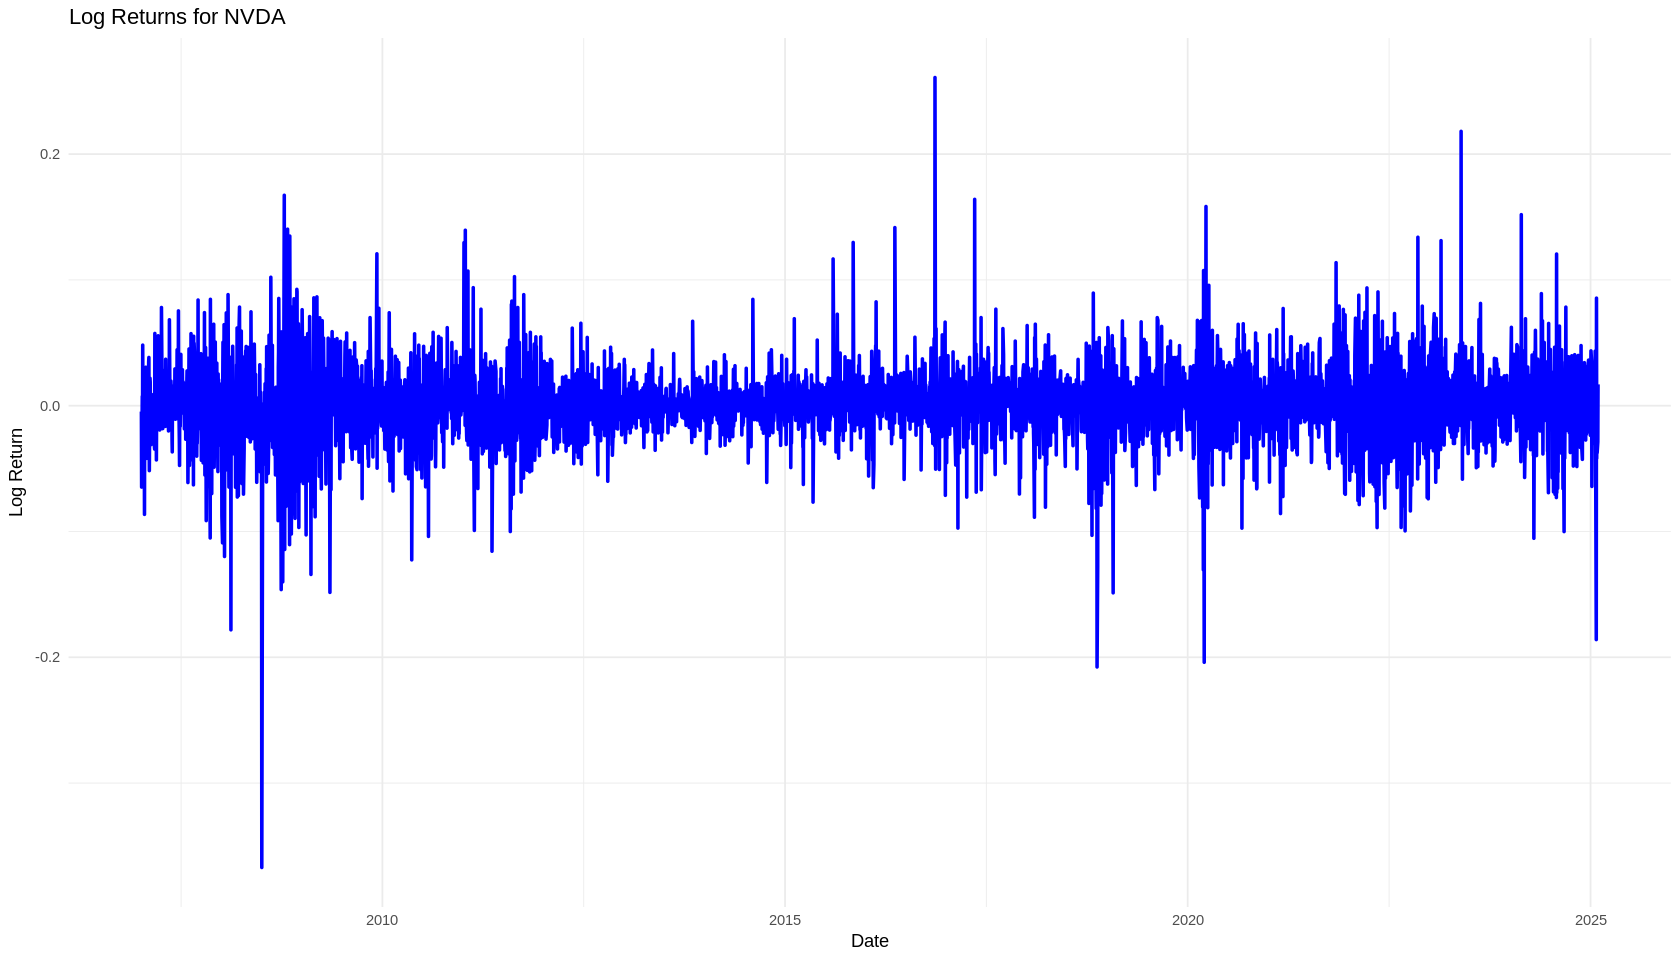

In [8]:
# Plot the data
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_all, aes(x = Date, y = LogReturn)) +
  geom_line(color = "blue", linewidth = 1) +
  labs(title = paste("Log Returns for", symbol),
       x = "Date",
       y = "Log Return") +
  theme_minimal()

# Data Preparation

In [9]:
# Split data into training and test sets
split_data <- function(data, train_frac = 0.8) {
  n <- nrow(data)
  train <- data[1:floor(train_frac * n), ]
  test  <- data[(floor(train_frac * n) + 1):n, ]
  list(train = train, test = test)
}

splits <- split_data(data_all, train_frac = 0.8)
train_data <- splits$train
test_data  <- splits$test

In [10]:
# Training data
head(train_data)
cat("\n")
str(train_data)

,Date,Close,LogReturn
,<date>,<dbl>,<dbl>
2,2007-01-04,0.5488755,-0.004722449
3,2007-01-05,0.5144849,-0.064705488
4,2007-01-08,0.5183063,0.007400122
5,2007-01-09,0.5082182,-0.019655472
6,2007-01-10,0.5332851,0.048145321
7,2007-01-11,0.5312977,-0.003733669



'data.frame':	3640 obs. of  3 variables:
 $ Date     : Date, format: "2007-01-04" "2007-01-05" ...
 $ Close    : num  0.549 0.514 0.518 0.508 0.533 ...
 $ LogReturn: num  -0.00472 -0.06471 0.0074 -0.01966 0.04815 ...
 - attr(*, "na.action")= 'omit' Named int 1
  ..- attr(*, "names")= chr "1"


In [11]:
# Test data
head(test_data)
cat("\n")
str(test_data)

,Date,Close,LogReturn
,<date>,<dbl>,<dbl>
3642,2021-06-21,18.39116,-0.011412433
3643,2021-06-22,18.84976,0.024630225
3644,2021-06-23,19.01992,0.008986785
3645,2021-06-24,19.16788,0.007749244
3646,2021-06-25,18.99372,-0.009127561
3647,2021-06-28,19.94586,0.048912946



'data.frame':	911 obs. of  3 variables:
 $ Date     : Date, format: "2021-06-21" "2021-06-22" ...
 $ Close    : num  18.4 18.8 19 19.2 19 ...
 $ LogReturn: num  -0.01141 0.02463 0.00899 0.00775 -0.00913 ...
 - attr(*, "na.action")= 'omit' Named int 1
  ..- attr(*, "names")= chr "1"


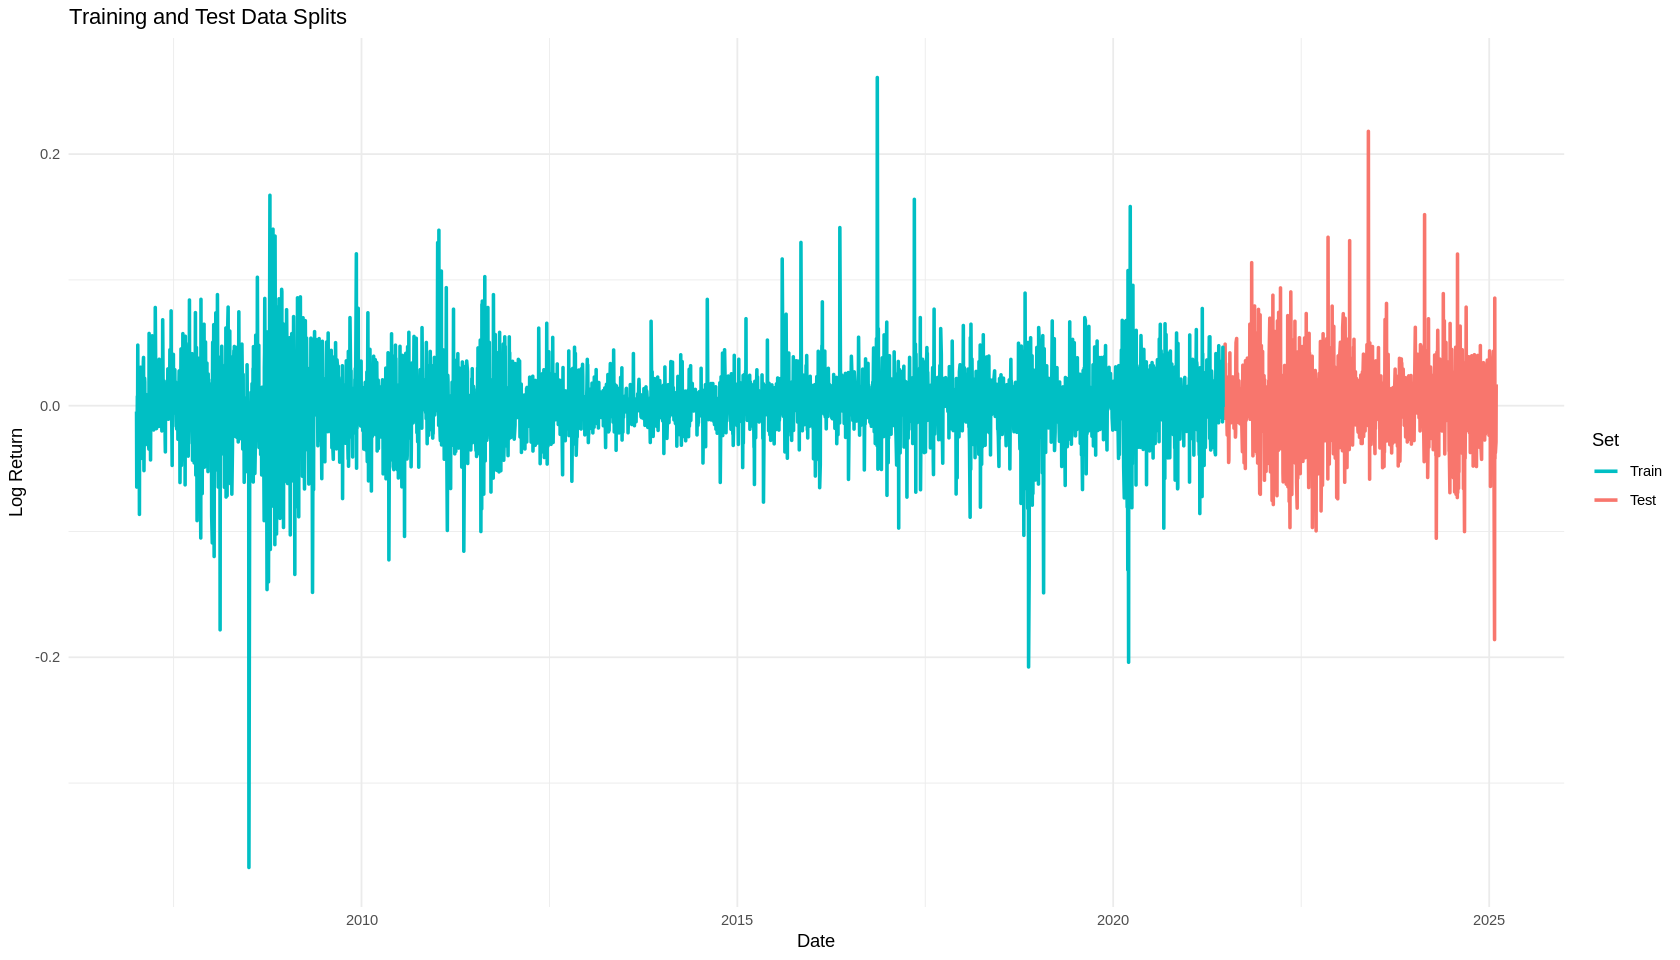

In [12]:
# Add an indicator column to each split
train_data_plot <- train_data %>% mutate(Set = "Train")
test_data_plot  <- test_data %>% mutate(Set = "Test")

# Combine the two datasets into one dataframe
plot_df <- bind_rows(train_data_plot, test_data_plot)

# Plot the splits
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(plot_df, aes(x = Date, y = LogReturn, color = Set)) +
  geom_line(linewidth = 1) +
  labs(title = "Training and Test Data Splits",
       x = "Date", y = "Log Return") +
  theme_minimal() +
  guides(color = guide_legend(reverse = TRUE))

# Model Tuning

In [13]:
# Time-series split function
TimeSeriesSplit <- function(
  data,
  n_splits = 5,
  test_size = NULL,
  max_train_size = NULL,
  gap = 0
) {

  # data: a dataframe or matrix with observations in rows
  n <- nrow(data)

  # If test_size is not provided, default to floor(n / (n_splits + 1))
  if (is.null(test_size)) {
    test_size <- floor(n / (n_splits + 1))
  }

  splits <- vector("list", n_splits)

  # Generate splits:
  # For the i-th split (i = 0, ..., n_splits - 1)
  # The training set covers observations from 1 to (i+1) * test_size
  # The test set starts after a gap and spans test_size observations
  for (i in 0:(n_splits - 1)) {
    train_end <- (i + 1) * test_size
    if (train_end > n) break  # Exit if training end exceeds data size

    # Determine training indices
    train_indices <- 1:train_end
    if (!is.null(max_train_size) && length(train_indices) > max_train_size) {
      # Keep only the most recent max_train_size observations
      train_indices <- tail(train_indices, max_train_size)
    }

    # Calculate test set indices
    test_start <- train_end + gap + 1
    test_end <- min(train_end + gap + test_size, n)
    if (test_start > n) break  # No test set possible

    test_indices <- test_start:test_end

    splits[[i + 1]] <- list(train = train_indices, test = test_indices)
  }

  return(splits)
}

In [14]:
# Create example data
example_data <- data.frame(value = 1:50)

# Test the function
tscv <- TimeSeriesSplit(example_data, n_splits = 3, gap = 0)

# Print the splits
for (i in seq_along(tscv)) {
  cat(sprintf("Fold %d:\n", i))
  cat("  Train indices:", tscv[[i]]$train, "\n")
  cat("  Test indices: ", tscv[[i]]$test, "\n\n")
}

Fold 1:
  Train indices: 1 2 3 4 5 6 7 8 9 10 11 12 
  Test indices:  13 14 15 16 17 18 19 20 21 22 23 24 

Fold 2:
  Train indices: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
  Test indices:  25 26 27 28 29 30 31 32 33 34 35 36 

Fold 3:
  Train indices: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
  Test indices:  37 38 39 40 41 42 43 44 45 46 47 48 



In [15]:
# Function to convert indices to splits
convert_cv_splits <- function(data, splits) {
  lapply(splits, function(split) {
    list(train = data[split$train, , drop = FALSE],
         test  = data[split$test, , drop = FALSE])
  })
}

# Generate CV splits for tuning
cv_indices <- TimeSeriesSplit(train_data, n_splits = 3, gap = 0)
cv_splits <- convert_cv_splits(train_data, cv_indices)

In [16]:
# Validate the number of splits and sample sizes
cat("CV Splits Validation:\n")
cat(sprintf("Expected number of splits: %d; Actual: %d\n", 3, length(cv_splits)))
for (i in seq_along(cv_splits)) {
  split <- cv_splits[[i]]
  cat(sprintf("Fold %d: Train size = %d, Test size = %d\n",
              i, nrow(split$train), nrow(split$test)))
  if (max(as.numeric(rownames(split$train))) >= min(as.numeric(rownames(split$test)))) {
    warning(sprintf("Fold %d: Training indices are not strictly before test indices!", i))
  }
}

CV Splits Validation:
Expected number of splits: 3; Actual: 3
Fold 1: Train size = 910, Test size = 910
Fold 2: Train size = 1820, Test size = 910
Fold 3: Train size = 2730, Test size = 910


In [17]:
# Function to approximate QLIKE
QLIKE <- function(realized_var, forecast_var, eps = 1e-9) {
  # realized_var = r_t^2
  # forecast_var = sigma_t^2 from the GARCH model
  # eps to avoid log(0)
  mean( (realized_var + eps) / (forecast_var + eps)
        - log((realized_var + eps) / (forecast_var + eps))
        - 1 )
}

In [18]:
# Function to evaluate a candidate on a fold
evaluate_candidate <- function(cv_split, candidate, target_col = "LogReturn") {
  train <- cv_split$train
  test  <- cv_split$test

  # Verify numeric
  if (!is.numeric(train[[target_col]])) {
    stop(paste("The column", target_col, "in train is not numeric!"))
  }

  # 1) Create the GARCH specification for volatility
  spec_candidate <- ugarchspec(
    variance.model = list(
      model = "sGARCH",
      garchOrder = c(candidate$gp, candidate$gq)
    ),
    mean.model = list(
      armaOrder = c(candidate$p, candidate$q),
      include.mean = TRUE,
      arfima = candidate$arfima
    ),
    distribution.model = "norm"
  )

  # 2) Fit the model
  fit <- tryCatch({
    ugarchfit(
      spec = spec_candidate,
      data = train[[target_col]],
      solver = "solnp"
    )
  }, error = function(e) {
    cat("Error in ugarchfit:", e$message, "\n")
    return(NULL)
  })

  if (is.null(fit)) return(Inf)

  # 3) Forecast
  fc <- tryCatch({
    ugarchforecast(fit, n.ahead = nrow(test))
  }, error = function(e) {
    cat("Error in ugarchforecast:", e$message, "\n")
    return(NULL)
  })

  if (is.null(fc)) return(Inf)

  # 4) Extract forecasted volatility
  pred_sigma <- as.numeric(fc@forecast$sigmaFor)
  pred_var   <- pred_sigma^2

  # 5) Compare to approximated realized variance
  realized_var <- test[[target_col]]^2

  # 6) Calculate QLIKE as the volatility error metric
  qlike_val <- QLIKE(realized_var, pred_var)

  # Return the QLIKE value
  return(qlike_val)
}

In [19]:
# Function to evaluate across all folds
tune_candidate <- function(candidate, cv_splits, target_col = "LogReturn") {
  qlike_values <- sapply(cv_splits, function(split) {
    evaluate_candidate(split, candidate, target_col = "LogReturn")
  })

  # Return mean QLIKE over folds
  mean(qlike_values, na.rm = TRUE)
}

In [20]:
# Function to run the tuning process
run_tuning <- function(tuning_grid, cv_splits, target_col = "LogReturn") {
  tuning_grid$avg_QLIKE <- apply(tuning_grid, 1, function(row) {
    candidate <- as.list(row)
    tune_candidate(candidate, cv_splits, target_col = target_col)
  })

  # Return the grid with the QLIKE scores
  tuning_grid
}

In [21]:
# Function to create candidate grid
create_tuning_grid <- function(
    p_range = 0:2,
    q_range = 0:2,
    gp_range = c(1,2),
    gq_range = c(1,2),
    arfima = FALSE) {
  expand.grid(
    p = p_range,
    q = q_range,
    gp = gp_range,
    gq = gq_range,
    arfima = arfima,
    stringsAsFactors = FALSE
)}

In [22]:
# Create the candidate grid
grid <- create_tuning_grid(
    p_range = 0:2,
    q_range = 0:2,
    gp_range = c(1,2),
    gq_range = c(1,2),
    arfima = TRUE
)

print(grid)

   p q gp gq arfima
1  0 0  1  1   TRUE
2  1 0  1  1   TRUE
3  2 0  1  1   TRUE
4  0 1  1  1   TRUE
5  1 1  1  1   TRUE
6  2 1  1  1   TRUE
7  0 2  1  1   TRUE
8  1 2  1  1   TRUE
9  2 2  1  1   TRUE
10 0 0  2  1   TRUE
11 1 0  2  1   TRUE
12 2 0  2  1   TRUE
13 0 1  2  1   TRUE
14 1 1  2  1   TRUE
15 2 1  2  1   TRUE
16 0 2  2  1   TRUE
17 1 2  2  1   TRUE
18 2 2  2  1   TRUE
19 0 0  1  2   TRUE
20 1 0  1  2   TRUE
21 2 0  1  2   TRUE
22 0 1  1  2   TRUE
23 1 1  1  2   TRUE
24 2 1  1  2   TRUE
25 0 2  1  2   TRUE
26 1 2  1  2   TRUE
27 2 2  1  2   TRUE
28 0 0  2  2   TRUE
29 1 0  2  2   TRUE
30 2 0  2  2   TRUE
31 0 1  2  2   TRUE
32 1 1  2  2   TRUE
33 2 1  2  2   TRUE
34 0 2  2  2   TRUE
35 1 2  2  2   TRUE
36 2 2  2  2   TRUE


In [23]:
# Run the grid tuning
tuning_results <- run_tuning(
    grid,
    cv_splits,
    target_col = "LogReturn"
)

cat("\nTuning Results:\n")
print(tuning_results)

Warning message in .sgarchfit(spec = spec, data = data, out.sample = out.sample, :
“
ugarchfit-->warning: solver failer to converge.”



ugarchfilter-->error: parameters names do not match specification
Expected Parameters are: mu ar1 arfima omega alpha1 beta1 beta2
Error in ugarchforecast: Exiting 

Tuning Results:
   p q gp gq arfima avg_QLIKE
1  0 0  1  1   TRUE  1.977906
2  1 0  1  1   TRUE  1.978219
3  2 0  1  1   TRUE  1.980148
4  0 1  1  1   TRUE  1.978097
5  1 1  1  1   TRUE  1.978173
6  2 1  1  1   TRUE  1.978695
7  0 2  1  1   TRUE  1.980467
8  1 2  1  1   TRUE  1.978534
9  2 2  1  1   TRUE  1.974082
10 0 0  2  1   TRUE  1.979804
11 1 0  2  1   TRUE  1.980041
12 2 0  2  1   TRUE  1.980163
13 0 1  2  1   TRUE  1.979949
14 1 1  2  1   TRUE  1.980031
15 2 1  2  1   TRUE  1.978183
16 0 2  2  1   TRUE  1.980195
17 1 2  2  1   TRUE  1.978398
18 2 2  2  1   TRUE  1.974053
19 0 0  1  2   TRUE  1.980477
20 1 0  1  2   TRUE       Inf
21 2 0  1  2   TRUE  1.979133
22 0 1  1  2   TRUE  1.980639
23 1 1  1  2   TRUE  1.980005
24 2 1  1  2   TRUE  1.977092
25 0 2  1  2   TRUE  1.979066
26 1 2  1  2   TRUE  1.977058
27 2 2  

In [24]:
# Select the best candidate
best_candidate <- tuning_results %>%
  arrange(avg_QLIKE) %>%
  slice(1)
cat("Best candidate specification:\n")
print(best_candidate)

Best candidate specification:
  p q gp gq arfima avg_QLIKE
1 2 2  2  2   TRUE  1.972906


# Model Training

In [25]:
# Function to fit the tuned model
fit_final_model <- function(train, test, best_candidate, target_col = "LogReturn") {
  h <- nrow(test)

  spec_obj <- ugarchspec(
    variance.model = list(model = "sGARCH", garchOrder = c(best_candidate$gp, best_candidate$gq)),
    mean.model     = list(armaOrder = c(best_candidate$p, best_candidate$q),
                          include.mean = TRUE,
                          arfima = best_candidate$arfima),
    distribution.model = "norm"
  )

  fit_obj <- ugarchfit(spec = spec_obj,
                       data = train[[target_col]],
                       solver = "solnp")

  fc_obj <- ugarchforecast(fit_obj, n.ahead = h)

  list(fit = fit_obj, forecasts = fc_obj)
}

In [26]:
# Fit and predict with the model
final_model <- fit_final_model(
    train = train_data,
    test = test_data,
    best_candidate = best_candidate,
    target_col = "LogReturn"
)

fc_obj <- final_model$forecasts
mean_fc <- as.numeric(fc_obj@forecast$seriesFor)
sigma_fc <- as.numeric(fc_obj@forecast$sigmaFor)

# Model Evaluation

In [27]:
# Function to compute mean price forecasting metrics
compute_metrics <- function(actual, predicted) {
  data.frame(
    RMSE  = rmse(actual, predicted),
    MAE   = mae(actual, predicted),
    MAPE  = mean(abs((actual - predicted) / (actual + 1e-9))) * 100,
    sMAPE = mean(2 * abs(actual - predicted) / (abs(actual) + abs(predicted))) * 100,
    wMAPE = sum(abs(actual - predicted)) / sum(actual) * 100
  )
}

In [28]:
# Identify the last training price
last_train_price <- tail(train_data$Close, 1)

# Convert forecasted log returns to price forecasts
cumulative_returns <- cumsum(mean_fc)
price_fc <- last_train_price * exp(cumulative_returns)

In [29]:
# Compute mean price forecasting metrics
model_metrics <- compute_metrics(test_data$Close, price_fc)
cat("Test Set Metrics:\n")
model_metrics

Test Set Metrics:


RMSE,MAE,MAPE,sMAPE,wMAPE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
32.61147,27.70286,78.57195,48.6236,53.52661


In [30]:
# Function to plot mean price forecast vs. actual values
plot_mean_forecasts <- function(test, preds) {
  plot_df <- data.frame(Date = test$Date,
                        Actual = test$Close,
                        Forecast = preds)

  p <- ggplot(plot_df, aes(x = Date)) +
    geom_line(aes(y = Actual, color = "Actual"), linewidth = 1) +
    geom_line(aes(y = Forecast, color = "Forecast"), linetype = "dashed", linewidth = 1) +
    labs(title = "Actual vs. Forecasted Prices",
         y = "Price", x = "Date") +
    scale_color_manual("", values = c("Actual" = "blue",
                                      "Forecast" = "red")) +
    theme_minimal()
  print(p)
}

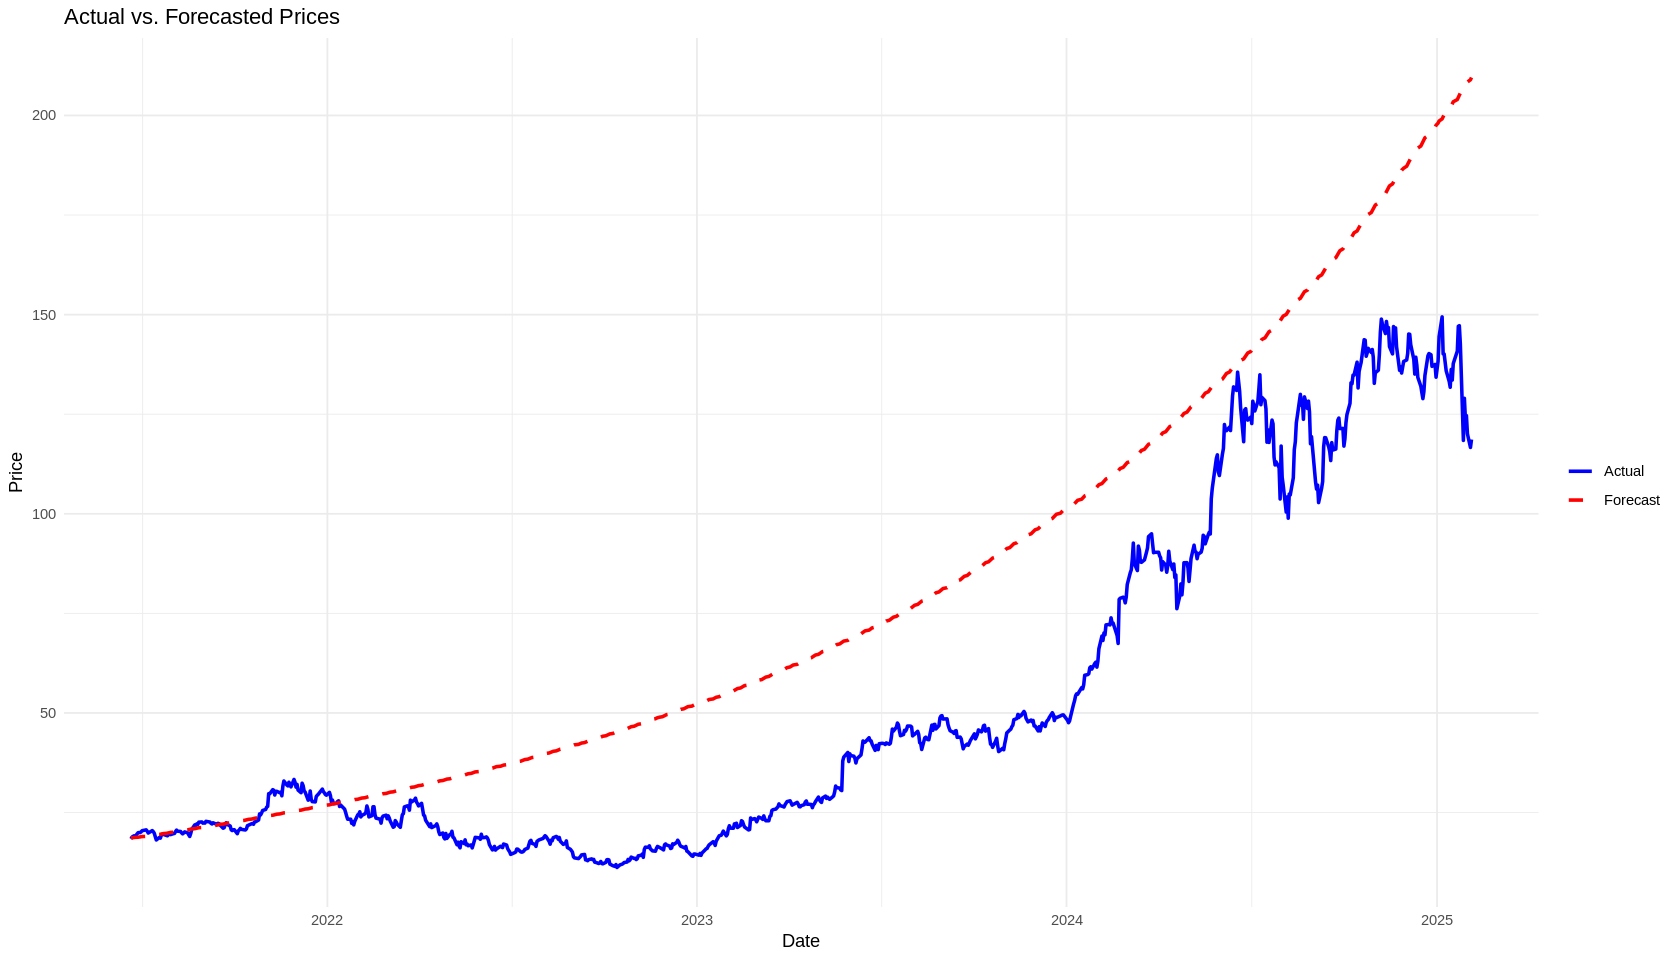

In [31]:
# Plot mean price forecast vs. actual values
options(repr.plot.width = 14, repr.plot.height = 8)
plot_mean_forecasts(
    test = test_data,
    preds = price_fc
)

In [32]:
# Function to plot forecasted volatility vs. realized volatility
plot_volatility_comparison <- function(test, fc, roll_width = 10) {
  # 1) Extract forecasted volatility in log-return space and annualize it
  forecast_sigma <- as.numeric(fc@forecast$sigmaFor) * sqrt(252)

  # 2) Compute realized volatility from rolling stdev of test's log returns
  # - test$LogReturn assumed to exist in the test data
  # - rollapply() yields an NA for the first (roll_width - 1) rows by default
  realized_vol <- rollapply(
    data       = test$LogReturn,
    width      = roll_width,
    FUN        = sd,
    fill       = NA,
    align      = "right"
  ) * sqrt(252)

  # 3) Build a plotting dataframe with equal length for all columns
  plot_df <- data.frame(
    Date            = test$Date,
    Realized_Vol    = realized_vol,
    Forecasted_Vol  = forecast_sigma
  )

  # Check for length mismatch just in case
  min_len <- min(nrow(plot_df), length(forecast_sigma))
  if (nrow(plot_df) != min_len) {
    # Truncate or handle mismatch if needed
    plot_df <- plot_df[seq_len(min_len), ]
  }

  # 4) Plot realized vs. forecasted volatility
  p <- ggplot(plot_df, aes(x = Date)) +
    geom_line(aes(y = Realized_Vol, color = "Realized Volatility"),
              linewidth = 1, na.rm = TRUE) +
    geom_line(aes(y = Forecasted_Vol, color = "Forecasted Volatility"),
              linetype = "dashed", linewidth = 1, na.rm = TRUE) +
    labs(
      title = "Realized vs. Forecasted Volatility",
      x     = "Date",
      y     = "Volatility (Annualized)"
    ) +
    scale_color_manual(
      "",
      values = c("Realized Volatility" = "blue",
                 "Forecasted Volatility" = "red")
    ) +
    theme_minimal()

  print(p)
}

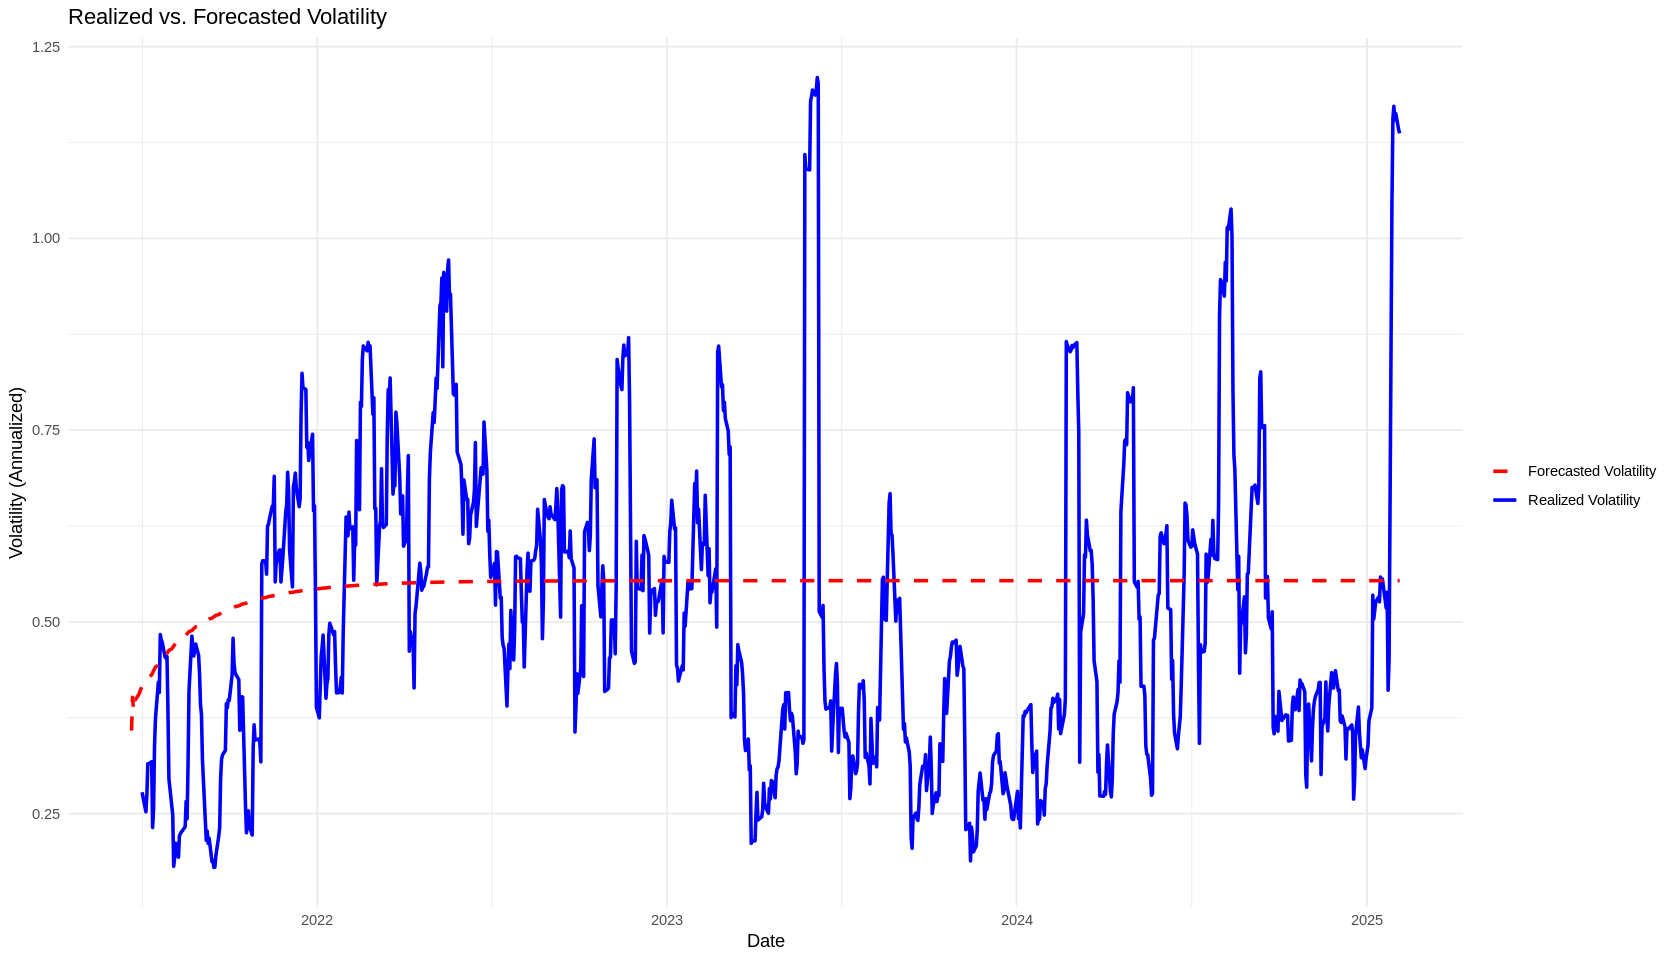

In [33]:
# Plot volatility
options(repr.plot.width = 14, repr.plot.height = 8)
plot_volatility_comparison(test = test_data, fc = final_model$forecasts, roll_width = 10)

In [34]:
# Function to plot residual diagnostics
volatility_residual_diagnostics <- function(fit) {
  std_resid <- residuals(fit, standardize = TRUE)
  par(mfrow = c(2, 2))
  acf(std_resid, main = "ACF of Standardized Residuals")
  acf(std_resid^2, main = "ACF of Squared Standardized Residuals")
  lb_test <- Box.test(std_resid^2, lag = 10, type = "Ljung-Box")
  print(lb_test)
  qqnorm(std_resid, main = "Q-Q Plot of Standardized Residuals")
  qqline(std_resid, col = "red")
  par(mfrow = c(1, 1))
}

Performing Residual Diagnostics...

	Box-Ljung test

data:  std_resid^2
X-squared = 2.8779, df = 10, p-value = 0.9842



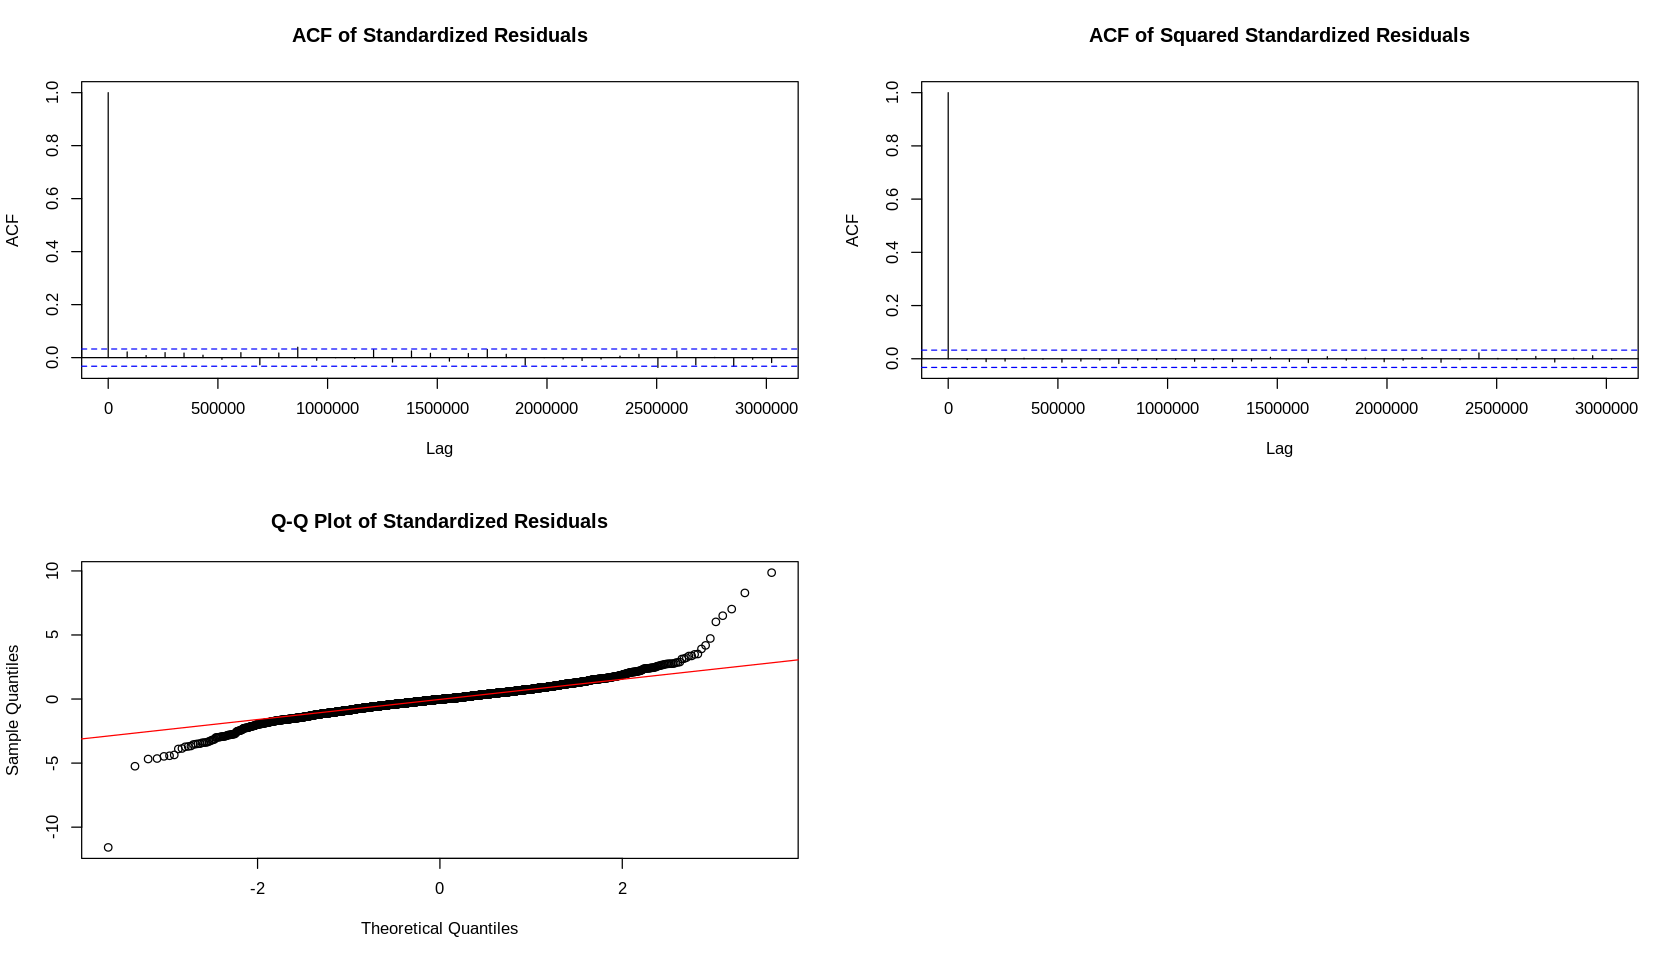

In [35]:
# Plot residual diagnostics
cat("Performing Residual Diagnostics...\n")
volatility_residual_diagnostics(final_model$fit)